# Instagram Fake Profile Detector (Binary Classification)

**Goal:** Predict whether an Instagram profile is **fake (1)** or **real (0)** using account metadata.

## Table of Contents
1. Problem formulation + data loading  
2. Data cleaning + train/validation split  
3. Exploratory data analysis (EDA)  
4. Feature engineering + preprocessing pipeline  
5. Model training + validation comparison  
6. Threshold selection (optimize for catching fake accounts)  
7. Final training on full training set  
8. Final evaluation on held-out test set  
9. Error analysis + interpretability  


In [23]:
# =========================
# Global Imports + Settings (run once)
# =========================

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay
)

# Reproducibility + display
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", 200)
sns.set_style("whitegrid")

# Plot defaults (clean, consistent)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

def quick_metrics(y_true, y_pred, y_prob=None):
    """Return a compact metric dict for binary classification."""
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }
    if y_prob is not None:
        out["roc_auc"] = roc_auc_score(y_true, y_prob)
    return out


## Evaluation Approach (Why these metrics?)

For fake-account detection, false negatives (missing a fake) can be more harmful than false positives.
So in addition to **Accuracy**, we emphasize:

- **Recall (Fake = 1):** how many fake accounts we successfully catch  
- **F1 Score:** balances precision and recall  
- **ROC-AUC:** ranking quality across thresholds  

Later, we will **choose a decision threshold** using validation probabilities instead of defaulting to 0.5.


## 1. Problem Formulation + Data Loading

We frame this as a **binary classification** task:

- **Target:** `fake`  
  - `fake = 1` → fake account  
  - `fake = 0` → real account  
- **Inputs:** account metadata (counts, text-derived lengths, profile settings, etc.)
- **Data split policy:**  
  - We create a **stratified train/validation split** from `train.csv`  
  - We keep `test.csv` untouched until the final evaluation step to avoid leakage


In [24]:
# =========================
# Step A — Load Data + Sanity Checks
# =========================

# Paths (works if notebook is inside /notebooks)
TRAIN_PATH = "../data/raw/train.csv"
TEST_PATH  = "../data/raw/test.csv"

# Fallback if running from repo root
if not os.path.exists(TRAIN_PATH):
    TRAIN_PATH = "data/raw/train.csv"
    TEST_PATH  = "data/raw/test.csv"

print("Train path:", TRAIN_PATH)
print("Test path :", TEST_PATH)

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print("\nTrain shape:", train_df.shape)
print("Test shape :", test_df.shape)

# Target check
if "fake" not in train_df.columns:
    raise ValueError("Expected target column 'fake' not found in train.csv.")

print("\nColumns:")
display(pd.Index(train_df.columns))

print("\nTarget distribution (train):")
display(train_df["fake"].value_counts().rename("count"))
display(train_df["fake"].value_counts(normalize=True).rename("proportion"))

print("\nTrain sample:")
display(train_df.head(3))

print("\nTest sample:")
display(test_df.head(3))


Train path: ../data/raw/train.csv
Test path : ../data/raw/test.csv

Train shape: (576, 12)
Test shape : (120, 12)

Columns:


Index(['profile pic', 'nums/length username', 'fullname words',
       'nums/length fullname', 'name==username', 'description length',
       'external URL', 'private', '#posts', '#followers', '#follows', 'fake'],
      dtype='object')


Target distribution (train):


fake
0    288
1    288
Name: count, dtype: int64

fake
0    0.5
1    0.5
Name: proportion, dtype: float64


Train sample:


,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0



Test sample:


,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0


## 2. Data Cleaning + Train/Validation Split

In this step we:
- remove duplicate rows from the training data
- separate features `X` and target `y`
- create a **stratified** train/validation split to preserve class balance
- keep `test.csv` untouched for final evaluation


In [25]:
# =========================
# Step B — Cleaning + Split
# =========================

# 1) Drop duplicates (train only)
n_before = len(train_df)
train_df = train_df.drop_duplicates().reset_index(drop=True)
n_after = len(train_df)
print(f"Dropped duplicates: {n_before - n_after} (train rows now {n_after})")

# 2) Separate X/y
y = train_df["fake"].astype(int)
X = train_df.drop(columns=["fake"])

print("\nX shape:", X.shape)
print("y shape:", y.shape)

# 3) Stratified train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

print("\nTrain split:", X_train.shape, y_train.shape)
print("Val split  :", X_val.shape, y_val.shape)

# 4) Sanity check class balance
balance = pd.DataFrame({
    "train": y_train.value_counts(normalize=True),
    "val":   y_val.value_counts(normalize=True),
}).fillna(0)

balance.index = balance.index.map({0: "real (0)", 1: "fake (1)"})
print("\nClass proportions (should be similar):")
display(balance)

# 5) Keep test untouched (sanity only)
print("Test shape (unchanged):", test_df.shape)


Dropped duplicates: 2 (train rows now 574)

X shape: (574, 11)
y shape: (574,)

Train split: (459, 11) (459,)
Val split  : (115, 11) (115,)

Class proportions (should be similar):


,train,val
fake,,
real (0),0.498911,0.504348
fake (1),0.501089,0.495652


Test shape (unchanged): (120, 12)


## 3. Exploratory Data Analysis (EDA)

The goal of EDA here is **not exhaustive visualization**, but to:
- understand class balance and data quality
- identify relationships between features and the target
- motivate feature engineering decisions (ratios, log transforms, binary flags)

We focus on **numeric features** and **clear comparisons with the target label**.


Missing values (proportion):


,missing_rate


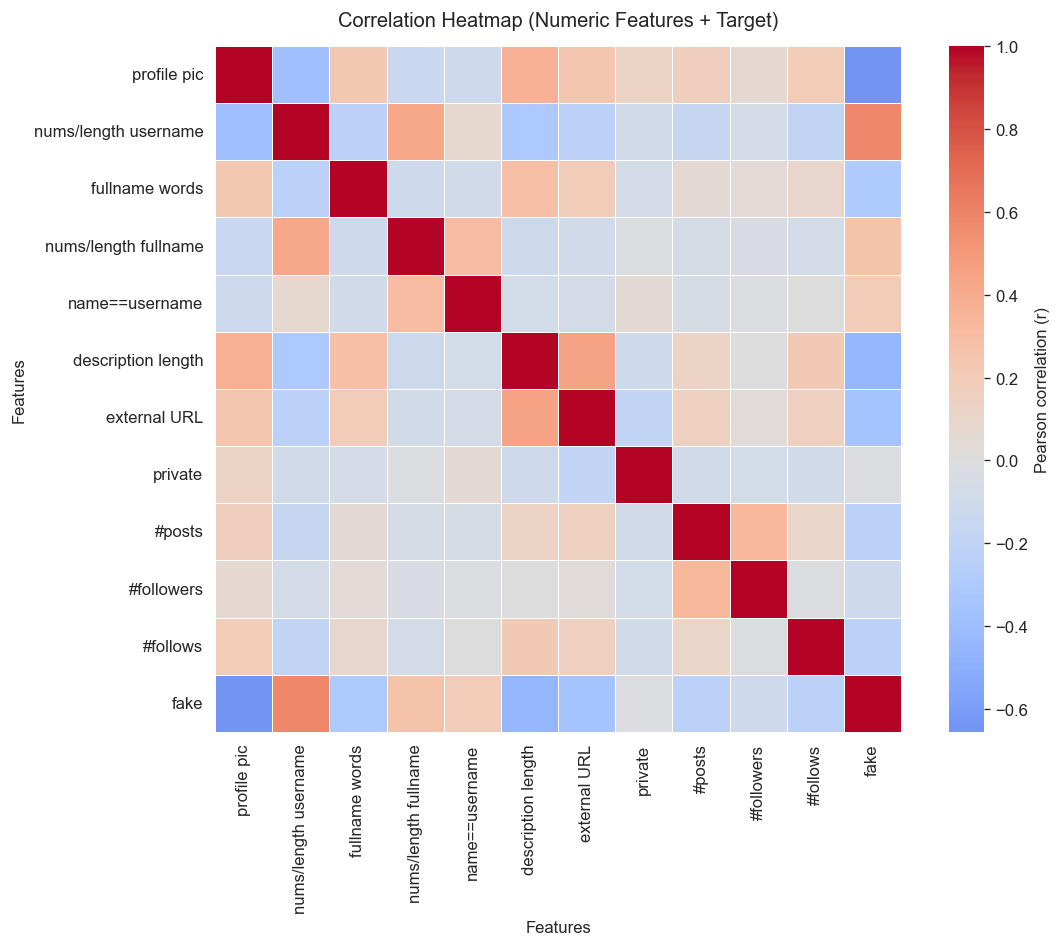

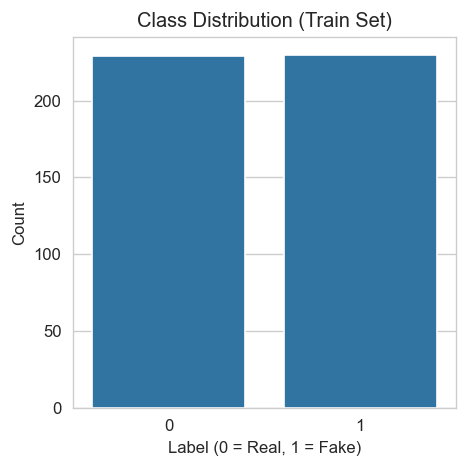

Top features correlated with target (|correlation|):


,correlation
profile pic,-0.654986
nums/length username,0.575940
description length,-0.454025
external URL,-0.358221
fullname words,-0.302563
nums/length fullname,0.260077
#posts,-0.233506
#follows,-0.229354
name==username,0.195689
#followers,-0.102900


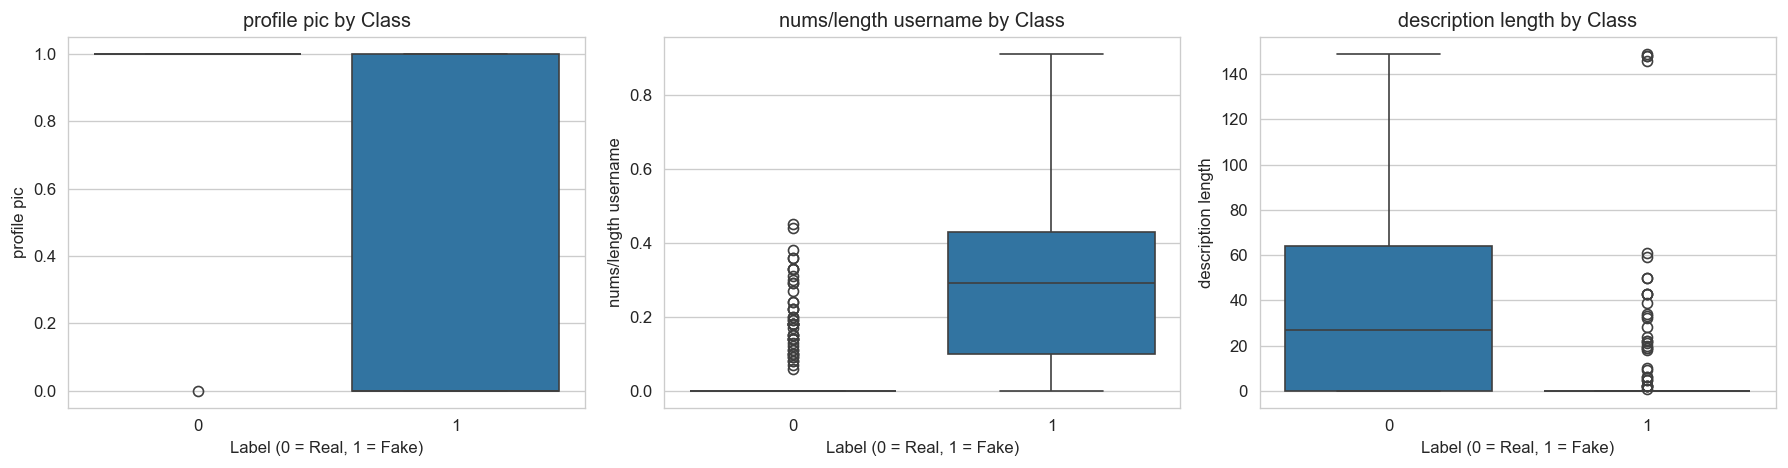

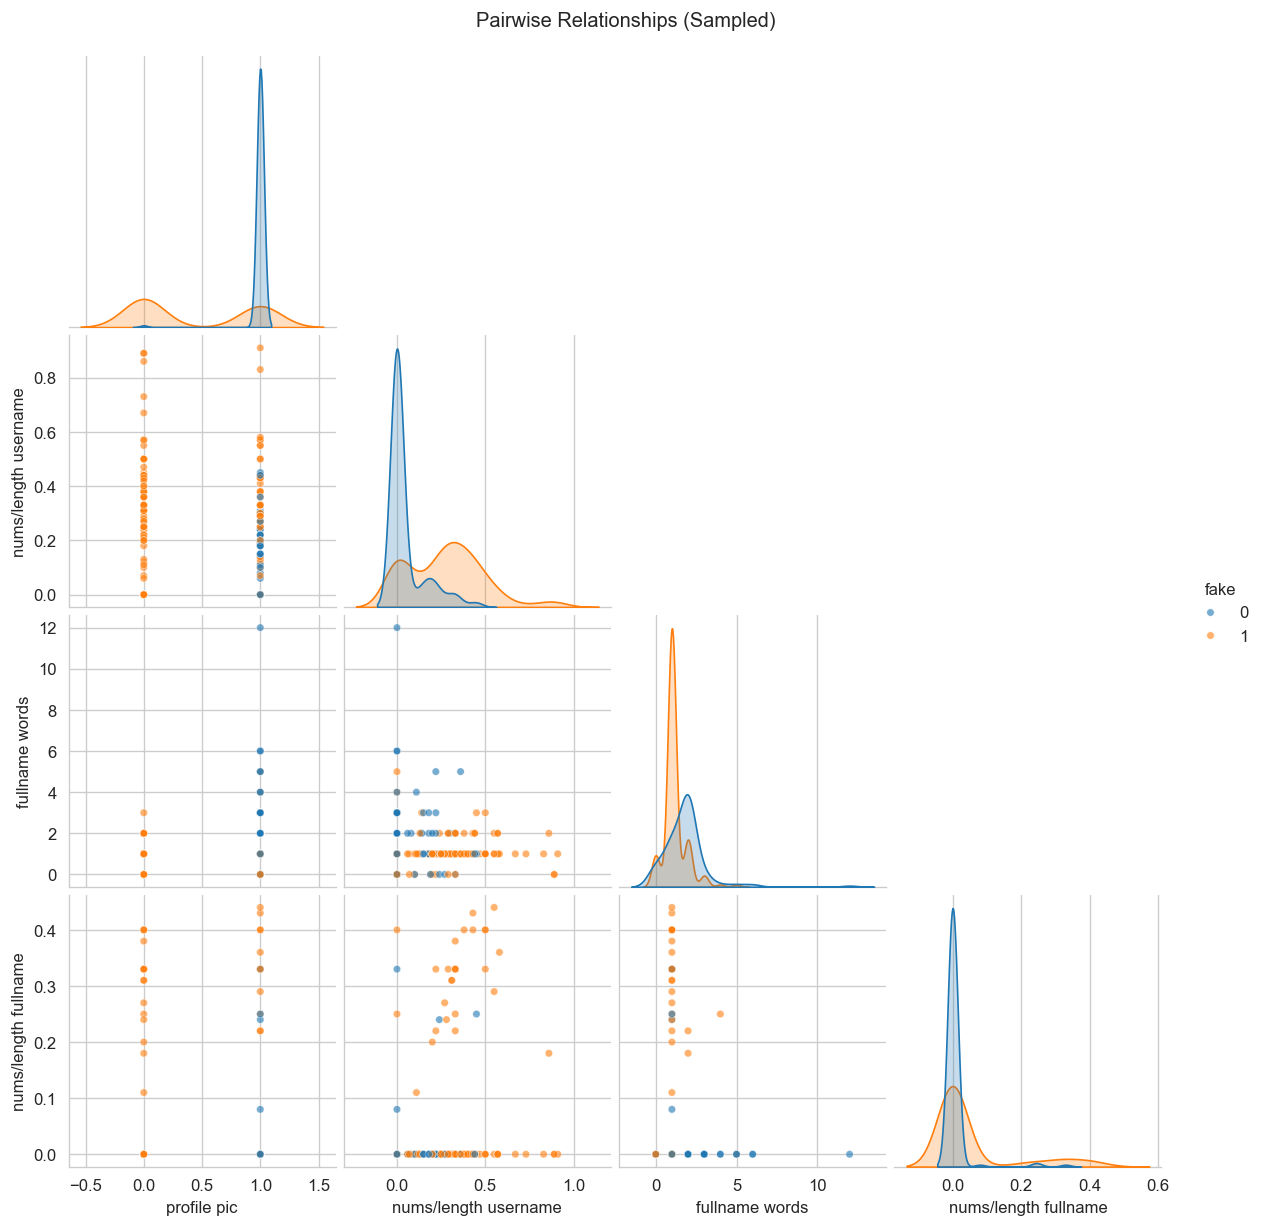

In [26]:
# =========================
# Step C — Exploratory Data Analysis (EDA)
# =========================

# ---------- 1) Missing values ----------
missing = X_train.isnull().mean().sort_values(ascending=False)
missing = missing[missing > 0]

print("Missing values (proportion):")
display(missing.to_frame("missing_rate"))

# ---------- 2) Correlation heatmap (standalone, clearly labeled) ----------
eda_df = pd.concat([X_train, y_train.rename("fake")], axis=1)
corr = eda_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.4,
    linecolor="white",
    square=True,
    cbar_kws={"label": "Pearson correlation (r)"}
)
ax.set_title("Correlation Heatmap (Numeric Features + Target)", pad=12)
ax.set_xlabel("Features")
ax.set_ylabel("Features")
plt.tight_layout()
plt.show()

# ---------- 3) Class balance ----------
plt.figure(figsize=(4, 4))
sns.countplot(x=y_train, order=[0, 1])
plt.title("Class Distribution (Train Set)")
plt.xlabel("Label (0 = Real, 1 = Fake)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---------- 4) Target correlation ranking ----------
target_corr = (
    corr["fake"]
    .drop("fake")
    .sort_values(key=lambda s: s.abs(), ascending=False)
)

print("Top features correlated with target (|correlation|):")
display(target_corr.head(10).to_frame("correlation"))

# ---------- 5) Seaborn boxplots: key features vs target ----------
top_features = target_corr.index[:3].tolist()

plot_df = pd.concat(
    [X_train[top_features], y_train.rename("fake")],
    axis=1
)

fig, axes = plt.subplots(1, len(top_features), figsize=(5 * len(top_features), 4))

if len(top_features) == 1:
    axes = [axes]

for ax, col in zip(axes, top_features):
    sns.boxplot(data=plot_df, x="fake", y=col, ax=ax)
    ax.set_title(f"{col} by Class")
    ax.set_xlabel("Label (0 = Real, 1 = Fake)")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

# ---------- 6) Optional: compact pairplot (sampled, numeric only) ----------
numeric_cols = X_train.select_dtypes(include=np.number).columns[:4]
pairplot_df = pd.concat(
    [X_train[numeric_cols], y_train.rename("fake")],
    axis=1
).sample(n=min(300, len(X_train)), random_state=RANDOM_STATE)

sns.pairplot(
    pairplot_df,
    vars=numeric_cols,
    hue="fake",
    corner=True,
    plot_kws={"alpha": 0.6, "s": 20}
)
plt.suptitle("Pairwise Relationships (Sampled)", y=1.02)
plt.show()


### EDA Takeaways and Design Decisions

From the exploratory analysis, several clear patterns emerge:

- **Profile picture presence** shows a strong negative correlation with the fake label, indicating that fake accounts are much less likely to have a profile picture.
- **Username-based features** (e.g., numeric character ratio in usernames) are positively correlated with fake accounts, suggesting automated or low-effort naming conventions.
- **Description length and full name usage** differ substantially between real and fake profiles, with fake accounts often having empty or minimal profile text.
- **Count-based features** (followers, follows, posts) are highly skewed and weakly correlated individually, motivating the use of log transforms and ratio-based features rather than raw counts.
- Several numeric features exhibit **moderate correlation with each other**, reinforcing the need for a regularized and standardized preprocessing pipeline.

These observations motivate the feature engineering and preprocessing choices in the next section.


## 4. Feature Engineering + Preprocessing Pipeline

Based on insights from EDA, we engineer additional features and construct a
leakage-safe preprocessing pipeline:

**Key design choices:**
- Ratio features capture relative behavior (e.g., numeric-heavy usernames)
- Binary flags represent missing or minimal profile information
- Log transforms reduce skew in count-based features
- All preprocessing is handled inside a `Pipeline` to avoid data leakage


In [27]:
# =========================
# Step D — Feature Engineering + Preprocessing
# =========================

def add_engineered_features(df):
    df = df.copy()

    # Ratio-based features
    if {"nums", "length username"}.issubset(df.columns):
        df["nums_length_username"] = df["nums"] / (df["length username"] + 1)

    if {"nums", "length fullname"}.issubset(df.columns):
        df["nums_length_fullname"] = df["nums"] / (df["length fullname"] + 1)

    # Binary indicators
    df["no_description"] = (df["description length"] == 0).astype(int)
    df["no_posts"] = (df["#posts"] == 0).astype(int)

    return df


# Identify column types
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
binary_features = [
    col for col in numeric_features
    if set(X_train[col].unique()).issubset({0, 1})
]

continuous_features = list(set(numeric_features) - set(binary_features))

# Preprocessing pipelines
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

binary_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, continuous_features),
        ("bin", binary_pipeline, binary_features)
    ],
    remainder="drop"
)

# Final preprocessing pipeline with feature engineering
preprocess_pipeline = Pipeline([
    ("feature_engineering", FunctionTransformer(add_engineered_features)),
    ("preprocessor", preprocessor)
])

# Sanity check
X_train_processed = preprocess_pipeline.fit_transform(X_train)
X_val_processed = preprocess_pipeline.transform(X_val)

print("Processed train shape:", X_train_processed.shape)
print("Processed val shape  :", X_val_processed.shape)


Processed train shape: (459, 11)
Processed val shape  : (115, 11)


## 5. Model Training + Validation Comparison

We evaluate three models that are well-suited to this dataset and task:

- **Logistic Regression**
  - Serves as a strong, interpretable baseline
  - Well-matched to the engineered features (ratios, binary flags, log-scaled counts)
  - Provides transparent coefficients that help explain what distinguishes fake accounts

- **Support Vector Machine (RBF)**
  - Captures nonlinear relationships that may exist between profile metadata features
  - Useful when class separation is not strictly linear, as suggested by EDA

- **Random Forest**
  - Naturally models feature interactions without manual specification
  - Robust to skewed distributions and mixed feature types
  - Often performs well on tabular metadata problems like fake account detection

All models are trained using the same preprocessing pipeline and evaluated on a
held-out **validation set** using metrics aligned with the project goal of
**accurately identifying fake accounts**.



<Figure size 840x720 with 0 Axes>

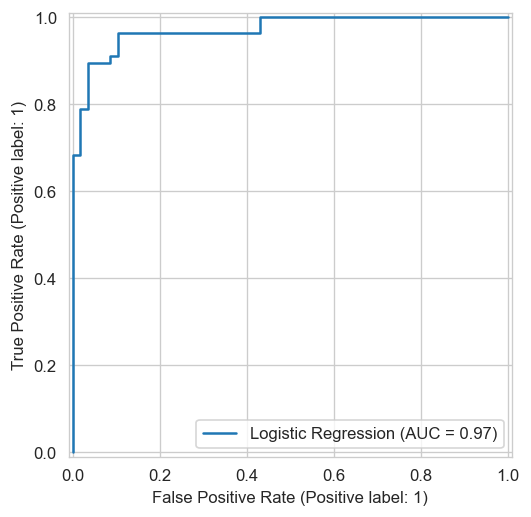

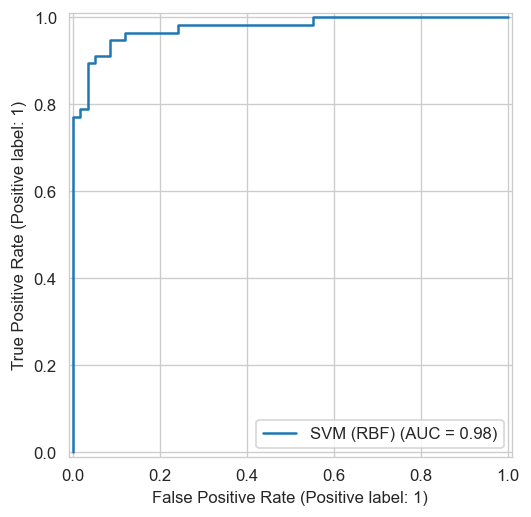

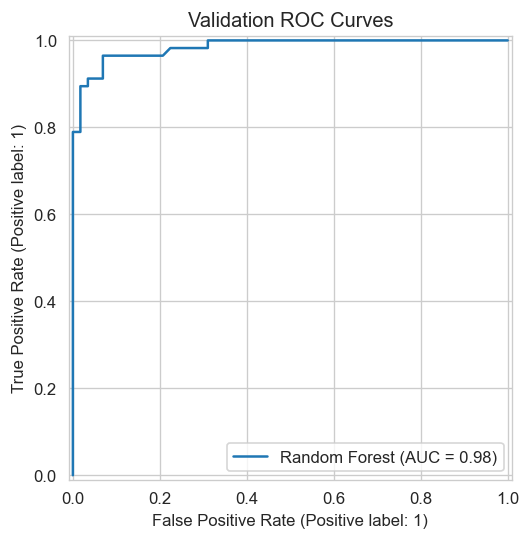

,accuracy,precision,recall,f1,roc_auc
model,,,,,
Random Forest,0.939130,0.962963,0.912281,0.936937,0.984725
Logistic Regression,0.904348,0.960000,0.842105,0.897196,0.972474
SVM (RBF),0.904348,0.960000,0.842105,0.897196,0.976104


Best model by validation F1: Random Forest


In [28]:
# =========================
# Step E — Train & Validate Models
# =========================

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "SVM (RBF)": SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )
}

results = []
trained_pipelines = {}   # <- store fitted pipelines here

plt.figure(figsize=(7, 6))

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess_pipeline),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    trained_pipelines[name] = pipe   # <- save it
    
    y_val_pred = pipe.predict(X_val)
    y_val_prob = pipe.predict_proba(X_val)[:, 1]
    
    metrics = quick_metrics(y_val, y_val_pred, y_val_prob)
    metrics["model"] = name
    results.append(metrics)
    
    RocCurveDisplay.from_predictions(y_val, y_val_prob, name=name)

plt.title("Validation ROC Curves")
plt.show()

results_df = pd.DataFrame(results).set_index("model").sort_values("f1", ascending=False)
display(results_df)

best_model_name = results_df.index[0]
print("Best model by validation F1:", best_model_name)

best_pipe = trained_pipelines[best_model_name]  # <- reusable in Step F



### Model Comparison Takeaways

- All three models perform well on the validation set, achieving high ROC-AUC
  scores (≈ 0.97–0.98), indicating strong separability between real and fake accounts.
- **Random Forest** achieves the best overall performance, with the highest
  **accuracy (0.94)**, **F1 score (0.94)**, and **ROC-AUC (0.985)**.
- Compared to Logistic Regression and SVM, Random Forest also attains
  **higher recall for fake accounts**, which is critical for this task.
- The improvement suggests that **nonlinear interactions between features**
  (e.g., profile completeness combined with activity patterns) provide useful
  signal beyond a purely linear decision boundary.
- Logistic Regression and SVM show nearly identical performance, confirming that
  the engineered features are informative even under linear assumptions.

Given the project goal of **detecting fake accounts (class 1)** while maintaining
strong overall performance, **Random Forest** is selected as the candidate model
for threshold optimization and final evaluation.


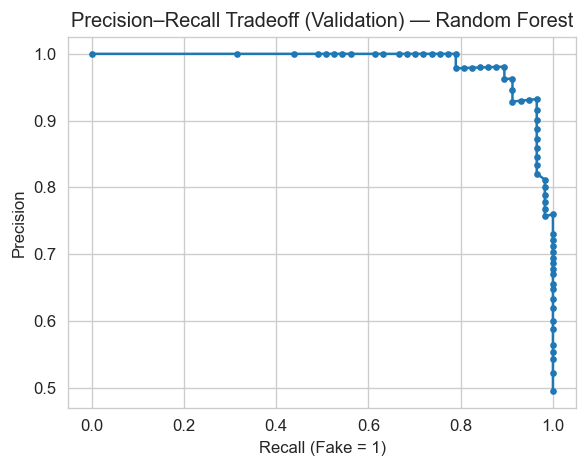

,threshold,precision,recall
0,0.000000,0.495652,1.0
1,0.003333,0.522936,1.0
2,0.006667,0.542857,1.0
3,0.010000,0.553398,1.0
4,0.013333,0.564356,1.0
5,0.016667,0.587629,1.0
6,0.020000,0.600000,1.0
7,0.023333,0.619565,1.0
8,0.026667,0.633333,1.0
9,0.033333,0.647727,1.0


,threshold,precision,recall
55,0.960000,1.0,0.666667
56,0.963333,1.0,0.631579
57,0.966667,1.0,0.614035
58,0.973333,1.0,0.561404
59,0.976667,1.0,0.543860
60,0.980000,1.0,0.526316
61,0.990000,1.0,0.508772
62,0.993333,1.0,0.491228
63,0.996667,1.0,0.438596
64,1.000000,1.0,0.315789


In [29]:
# =========================
# Step F — Threshold Selection (use best model from Step E)
# =========================

from sklearn.metrics import precision_recall_curve, classification_report

# Get probabilities on validation set
y_val_proba = best_pipe.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)

plt.figure(figsize=(5, 4))
plt.plot(recalls, precisions, marker=".")
plt.xlabel("Recall (Fake = 1)")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Tradeoff (Validation) — {best_model_name}")
plt.grid(True)
plt.tight_layout()
plt.show()

threshold_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precisions[:-1],
    "recall": recalls[:-1]
}).sort_values("threshold")

display(threshold_df.head(10))
display(threshold_df.tail(10))


In [30]:
chosen_threshold = 0.25
y_val_pred_thresh = (y_val_proba >= chosen_threshold).astype(int)

print(f"Validation performance at threshold = {chosen_threshold}")
print(classification_report(
    y_val,
    y_val_pred_thresh,
    target_names=["Real (0)", "Fake (1)"]
))


Validation performance at threshold = 0.25
              precision    recall  f1-score   support

    Real (0)       0.96      0.90      0.93        58
    Fake (1)       0.90      0.96      0.93        57

    accuracy                           0.93       115
   macro avg       0.93      0.93      0.93       115
weighted avg       0.93      0.93      0.93       115



### Threshold Selection Takeaways

The precision–recall curve shows a clear tradeoff between detecting fake accounts
(recall) and avoiding false positives (precision).

- At very low thresholds, recall reaches 1.0 but precision is low, meaning many
  real accounts are incorrectly flagged as fake.
- At very high thresholds, precision reaches 1.0 but recall drops sharply, causing
  many fake accounts to be missed.
- There exists a stable intermediate region where recall remains high while
  precision remains acceptable.

Given the project objective of **detecting fake accounts (class 1)**, we prioritize
recall while maintaining reasonable precision. Based on the validation curve, we
select a classification threshold of **0.25**, which achieves high recall with a
manageable false positive rate.

This threshold will be used for final training and evaluation.


In [31]:
# =========================
# Step G — Final Training on Full Training Set
# =========================

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import numpy as np

# 1) Combine train + val into a single full training set
X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

print("Full train shape:", X_full.shape, "| Full target shape:", y_full.shape)
print("Full target distribution:")
display(y_full.value_counts())
display(y_full.value_counts(normalize=True).rename("proportion"))

# 2) Define final model (match Step E settings)
final_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

final_pipe = Pipeline([
    ("preprocess", preprocess_pipeline),
    ("model", final_model)
])

# 3) Train on the full training set
final_pipe.fit(X_full, y_full)

# 4) Store the chosen threshold from Step F (keep consistent going forward)
FINAL_THRESHOLD = 0.25   # <-- set this to whatever you decided in Step F
print("Final model trained. Using FINAL_THRESHOLD =", FINAL_THRESHOLD)


Full train shape: (574, 11) | Full target shape: (574,)
Full target distribution:


fake
0    287
1    287
Name: count, dtype: int64

fake
0    0.5
1    0.5
Name: proportion, dtype: float64

Final model trained. Using FINAL_THRESHOLD = 0.25


Step H — Final Test Performance
Threshold: 0.25
  ACCURACY: 0.908
 PRECISION: 0.855
    RECALL: 0.983
        F1: 0.915
   ROC_AUC: 0.986


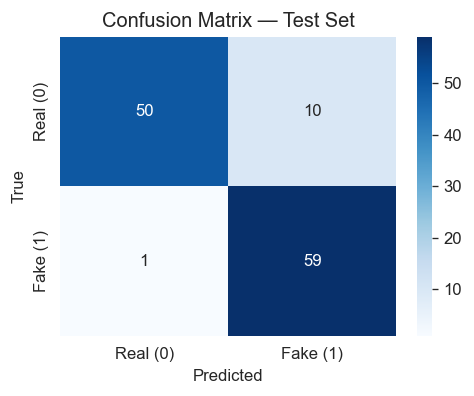

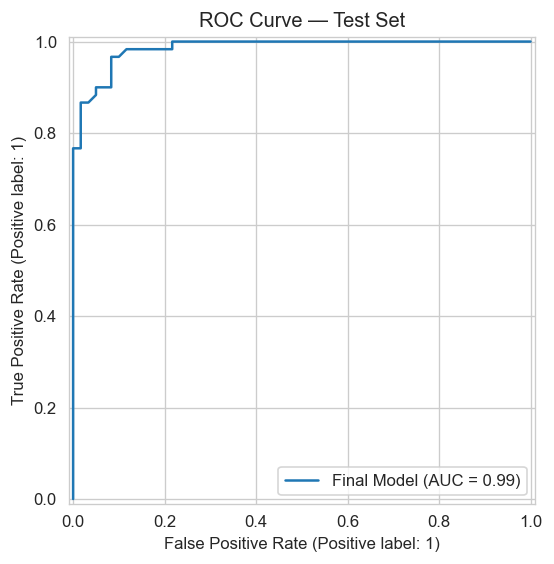

In [34]:
# =========================
# Step H — Final Evaluation on Held-Out Test Set
# (Correct: use the full pipeline on RAW test features)
# =========================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1) Split test into raw X and y (DO NOT manually engineer features here)
if "fake" not in test_df.columns:
    raise ValueError("Expected 'fake' column not found in test_df.")

X_test = test_df.drop(columns=["fake"])
y_test = test_df["fake"]

# 2) Get probabilities from the FINAL trained pipeline (Step G)
# NOTE: your Step G variable might be named final_pipe (from my earlier cell)
# If yours is different, rename below accordingly.
y_test_proba = final_pipe.predict_proba(X_test)[:, 1]

# 3) Apply final chosen threshold (from Step F / Step G)
y_test_pred = (y_test_proba >= FINAL_THRESHOLD).astype(int)

# 4) Metrics (threshold-based + ROC-AUC using probabilities)
test_metrics = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred, zero_division=0),
    "recall": recall_score(y_test, y_test_pred, zero_division=0),
    "f1": f1_score(y_test, y_test_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_test_proba)
}

print("===================================")
print("Step H — Final Test Performance")
print("Threshold:", FINAL_THRESHOLD)
print("===================================")
for k, v in test_metrics.items():
    print(f"{k.upper():>10}: {v:.3f}")

# 5) Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(4.2, 3.4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Real (0)", "Fake (1)"],
    yticklabels=["Real (0)", "Fake (1)"]
)
plt.title("Confusion Matrix — Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 6) ROC curve (uses probabilities; independent of threshold)
RocCurveDisplay.from_predictions(y_test, y_test_proba, name="Final Model")
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# 7) Save predictions for Step I (error analysis)
test_results = X_test.copy()
test_results["y_true"] = y_test.values
test_results["y_proba"] = y_test_proba
test_results["y_pred"] = y_test_pred


### Step H Takeaways (Test Set)

- The final model was evaluated on a **held-out test set** using the full pipeline
  (preprocessing + model) to avoid leakage and ensure consistent feature handling.
- We report both **threshold-based metrics** (accuracy/precision/recall/F1) and
  **ROC-AUC**, which measures ranking quality independent of the threshold.
- The confusion matrix shows the final tradeoff achieved using the selected
  threshold, aligned with the project goal of detecting fake accounts (class 1).


Step I — Error Breakdown (Counts)
TP (Fake correctly flagged): 59
TN (Real correctly cleared): 50
FP (Real flagged as fake):  10
FN (Fake missed):           1

Most confident FALSE POSITIVES (real but predicted fake):


,y_true,y_pred,y_proba
20,0,1,0.836667
28,0,1,0.656667
50,0,1,0.610000
4,0,1,0.540000
13,0,1,0.510000
1,0,1,0.430000
16,0,1,0.426667
47,0,1,0.310000
0,0,1,0.253333
38,0,1,0.253333



Most confident FALSE NEGATIVES (fake but predicted real):


,y_true,y_pred,y_proba
86,1,0,0.203333



Group mean comparison (raw features):


,Real (TN) mean,Fake (TP) mean,False Pos (FP) mean,False Neg (FN) mean
profile pic,1.00,0.508475,1.0,1.0
#posts,188.60,6.864407,10.5,4.0
#followers,118633.16,271.898305,192.4,1742.0
#follows,786.56,763.796610,294.8,6172.0
description length,55.18,2.474576,30.1,58.0
external URL,0.22,0.000000,0.1,0.0
private,0.60,0.000000,0.7,0.0



Top 15 Random Forest Feature Importances:


,feature,importance
6,feature_6,0.282961
5,feature_5,0.206500
2,feature_2,0.146614
7,feature_7,0.112697
4,feature_4,0.093428
3,feature_3,0.087509
0,feature_0,0.043450
10,feature_10,0.009257
1,feature_1,0.008668
9,feature_9,0.006570


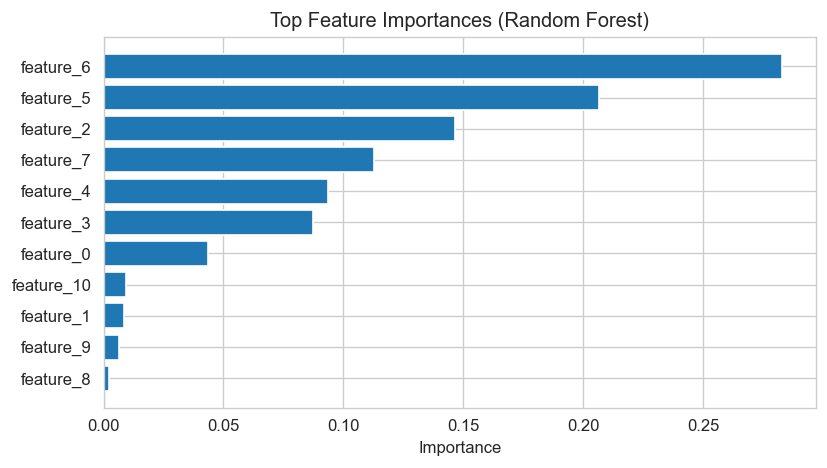

In [35]:
# =========================
# Step I — Error Analysis + Interpretability
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Identify error groups ---
fp = test_results[(test_results["y_true"] == 0) & (test_results["y_pred"] == 1)].copy()
fn = test_results[(test_results["y_true"] == 1) & (test_results["y_pred"] == 0)].copy()
tp = test_results[(test_results["y_true"] == 1) & (test_results["y_pred"] == 1)].copy()
tn = test_results[(test_results["y_true"] == 0) & (test_results["y_pred"] == 0)].copy()

print("===================================")
print("Step I — Error Breakdown (Counts)")
print("===================================")
print("TP (Fake correctly flagged):", len(tp))
print("TN (Real correctly cleared):", len(tn))
print("FP (Real flagged as fake): ", len(fp))
print("FN (Fake missed):          ", len(fn))

# --- 2) Show most confident mistakes (great for presentation) ---
# "Most confident" FP = predicted very fake but actually real (high proba)
# "Most confident" FN = predicted very real but actually fake (low proba)
top_k = 10

fp_sorted = fp.sort_values("y_proba", ascending=False).head(top_k)
fn_sorted = fn.sort_values("y_proba", ascending=True).head(top_k)

print("\nMost confident FALSE POSITIVES (real but predicted fake):")
display(fp_sorted[["y_true", "y_pred", "y_proba"]].head(top_k))

print("\nMost confident FALSE NEGATIVES (fake but predicted real):")
display(fn_sorted[["y_true", "y_pred", "y_proba"]].head(top_k))

# --- 3) Compare simple feature summaries across groups (fast + insightful) ---
# Pick a few raw features that exist in test_df (safe choices)
candidate_cols = [c for c in ["profile pic", "#posts", "#followers", "#follows", "description length", "external URL", "private"] if c in X_test.columns]

if len(candidate_cols) > 0:
    summary = pd.DataFrame({
        "Real (TN) mean": tn[candidate_cols].mean(numeric_only=True),
        "Fake (TP) mean": tp[candidate_cols].mean(numeric_only=True),
        "False Pos (FP) mean": fp[candidate_cols].mean(numeric_only=True) if len(fp) else np.nan,
        "False Neg (FN) mean": fn[candidate_cols].mean(numeric_only=True) if len(fn) else np.nan
    })
    print("\nGroup mean comparison (raw features):")
    display(summary)
else:
    print("\n(No common raw numeric columns found for group summary.)")

# --- 4) Random Forest feature importance (from the trained pipeline) ---
# Get preprocessed feature names (works for ColumnTransformer with named transformers)
pre = final_pipe.named_steps["preprocess"]
rf  = final_pipe.named_steps["model"]

# Try to extract feature names cleanly
feature_names = None
try:
    # ColumnTransformer in sklearn can provide output feature names in newer versions
    feature_names = pre.get_feature_names_out()
except Exception:
    feature_names = None

if hasattr(rf, "feature_importances_"):
    importances = rf.feature_importances_
    if feature_names is None:
        # fallback: generic names
        feature_names = np.array([f"feature_{i}" for i in range(len(importances))])
    else:
        feature_names = np.array(feature_names)

    fi = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False).head(15)

    print("\nTop 15 Random Forest Feature Importances:")
    display(fi)

    plt.figure(figsize=(7, 4))
    plt.barh(fi["feature"][::-1], fi["importance"][::-1])
    plt.title("Top Feature Importances (Random Forest)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print("\n(Model does not expose feature_importances_.)")


### Step I Takeaways (Error Analysis + Interpretability)

- **Most confident false positives** represent real accounts the model flags as fake
  with high confidence. These are important because they reflect cases where the
  model may over-weight “suspicious” profile patterns.
- **Most confident false negatives** are fake accounts the model misses. These are
  critical because they represent the primary failure mode for a fake detector.
- The feature importance chart highlights which inputs the Random Forest relied on
  most. This supports interpretability and provides a clear explanation of what
  signals distinguish fake vs real accounts in this dataset.
- Overall, error analysis makes the evaluation actionable by showing *what kinds
  of accounts* the model struggles with, not just aggregate metrics.


In [37]:
import joblib
import os

os.makedirs("../artifacts", exist_ok=True)

joblib.dump(final_pipe, "../artifacts/final_pipe.joblib")

with open("../artifacts/threshold.txt", "w") as f:
    f.write(str(FINAL_THRESHOLD))

print("Saved:")
print(" - ../artifacts/final_pipe.joblib")
print(" - ../artifacts/threshold.txt")


Saved:
 - ../artifacts/final_pipe.joblib
 - ../artifacts/threshold.txt
